In [ ]:
!unzip /content/train.zip

Archive:  /content/train.zip
  inflating: train/1_jpg.rf.2e6cce3e7cfc0e62b404ba5af96a9c38.jpg  
  inflating: train/1_jpg.rf.2e6cce3e7cfc0e62b404ba5af96a9c38.xml  
  inflating: train/10_jpg.rf.880b1bdec1500169ae9be5c3c1d11137.jpg  
  inflating: train/10_jpg.rf.880b1bdec1500169ae9be5c3c1d11137.xml  
  inflating: train/100_jpg.rf.74b204ede0834a099f56a41742941027.jpg  
  inflating: train/100_jpg.rf.74b204ede0834a099f56a41742941027.xml  
  inflating: train/101_jpg.rf.972a0fbe052e4248b14ee0ee2ddf7eae.jpg  
  inflating: train/101_jpg.rf.972a0fbe052e4248b14ee0ee2ddf7eae.xml  
  inflating: train/102_jpg.rf.0387b37b73d94171ea62858a3daab7dc.jpg  
  inflating: train/102_jpg.rf.0387b37b73d94171ea62858a3daab7dc.xml  
  inflating: train/103_jpg.rf.0e8e30f22d765b17cdac459d8f5342b4.jpg  
  inflating: train/103_jpg.rf.0e8e30f22d765b17cdac459d8f5342b4.xml  
  inflating: train/105_jpg.rf.201d7b3e3e06c720e974070b93d18c26.jpg  
  inflating: train/105_jpg.rf.201d7b3e3e06c720e974070b93d18c26.xml  
  inflating

In [ ]:
!unzip /content/test.zip

Archive:  /content/test.zip
  inflating: test/1000_jpg.rf.884968f09695e4a51b03989a0de3945e.jpg  
  inflating: test/1000_jpg.rf.884968f09695e4a51b03989a0de3945e.xml  
  inflating: test/107_jpg.rf.cde52d96d00fd611d4c474f3f461531a.jpg  
  inflating: test/107_jpg.rf.cde52d96d00fd611d4c474f3f461531a.xml  
  inflating: test/11_jpg.rf.24a3119114e678ee91ba46184778a620.jpg  
  inflating: test/11_jpg.rf.24a3119114e678ee91ba46184778a620.xml  
  inflating: test/12_jpg.rf.faf6cc599e50356a41e7ffa3b4ea3893.jpg  
  inflating: test/12_jpg.rf.faf6cc599e50356a41e7ffa3b4ea3893.xml  
  inflating: test/122_jpg.rf.9eb762789b8f23ba4026abe5fdca5b80.jpg  
  inflating: test/122_jpg.rf.9eb762789b8f23ba4026abe5fdca5b80.xml  
  inflating: test/124_jpg.rf.c7c76758f6f7a9ebf40e7e07846e2f06.jpg  
  inflating: test/124_jpg.rf.c7c76758f6f7a9ebf40e7e07846e2f06.xml  
  inflating: test/128_jpg.rf.7da422e5284716b9bed69611802aacda.jpg  
  inflating: test/128_jpg.rf.7da422e5284716b9bed69611802aacda.xml  
  inflating: test/130_

In [ ]:
# Importamos las librerías necesarias
import numpy as np
import xml.etree.ElementTree as ET
import os
from PIL import Image
import tensorflow
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
import cv2

# Se importan las librerías para implementar el paralelismo:
from concurrent import futures

In [ ]:
# Cargamos las clases del dataset y le asignamos un número. Se guardán en forma de clave, valor en un diccionario.
clases = ["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]
etiquetas = {clase: ide for ide, clase in enumerate(clases)}


# Ahora, se crea una función para procesar las imágenes, ya que se hará un 'reshape' para que se tenga la misma forma en todas las img.
def Imagenes(path_img):
    # Se lee la imagen

    # Leemos las imágenes y se realiza la conversión en RGB
    Imagen = Image.open(path_img).convert("RGB")


    # Finalmente, se hace el resize para que cada imagen tenga la misma forma (se mantienen los 3 canales RGB)
    Imagen=Imagen.resize((224, 224))


    # Dicha imagen, es a un arreglo de numpy
    Imagen = np.array(Imagen)


    return Imagen


# Debido a que las anotaciones del etiquetado están en un archivo XML, se procederá a extraer la información
# necesaria, como los bordes de las anotaciones y su clase correspondiente de la imagen. Para ello, se hará uso
# de la librería xml.etree.ElementTree
def Data(xml_ruta):
    # Creamos las listas donde se almacenará la imagen, los bordes de las anotaciones y clase
    targets=[]
    clase=[]
    imagen=[]

    # Ya que se tienen las rutas de los archivos xml, se procederá a obtener la información necesaria de cada uno de ellos
    # Sin embargo, antes de proceder con la lectura de los xml, debemos aprovechar que los nombres de las imgs son iguales al de los xlm,
    # así que también las leemos, ya que deben ser almacenadas para entrenar a la red neuronal
    img_ruta = xml_ruta.replace(".xml", ".jpg")  # cambiamos el .xml a .jpg para tener las rutas de cada imagen

    # Ya que se tiene la ruta de la imagen, la mandamos a procesar para realizar el resize mediante la función que creamos al inicio
    img = Imagenes(img_ruta)


     # Se lee el archivo xml
    arc_xml = ET.parse(xml_ruta)

    # Ahora, se obtiene el elemento "raíz" de ese archivo, para a partir de él iterar los demás elementos en el archivo xml
    elem_root = arc_xml.getroot()

    # Se procederá con la iteración,a partir del elemento raíz, en busca de la información que se quiere obtener
    # Se selecciona el elemento hijo "object" del elemento root, pues aquí se encuentra la información que buscamos
    for elem in elem_root.findall('object'):
        # Ya que nos situamos en "object", obtenemos la clase de la imagen, que está ubicada en "name" (en el archivo xml)
        etiq = elem.find('name').text

        # Sin embargo, lo que se quiere obtener es el valor numérico de dicha clase, entonces usamos el diccionario que creamos al inicio
        etiq_ide = etiquetas.get(etiq)

        # Obtenemos el ancho y alto de cada imagen
        width = int(elem_root.find('size').find('width').text)
        height = int(elem_root.find('size').find('height').text)

        # Obtenemos, ahora, las posiciones de los bordes donde se encuentran los objetos en las imágenes
        # Para ello, nos situamos dentro de "bndbox", que a su vez se encuentra dentro de "object"
        box = elem.find('bndbox')

        # Procedemos a obtener las posiciones correspondientes y se divide, pues se hizo un resize de la imagen
        xmin = int(int(box.find('xmin').text) / (width / 224))
        ymin = int(int(box.find('ymin').text) / (height / 224))
        xmax = int(int(box.find('xmax').text) / (width / 224))
        ymax = int(int(box.find('ymax').text) / (height / 224))

        # Ahora, guardamos cada uno de los datos en las listas "imagenes","targets", en donde mencionamos que serían almacenados
        targets.append([xmin, ymin, xmax, ymax])
        clase.append(etiq_ide)
        imagen.append(img)
    return targets, clase, imagen


In [ ]:
if __name__=="__main__":
    # Para paralelizar el código, se necesitará una función que debe ser la "tarea" a asignar para cada proceso:
    train_path = "/content/train"
    test_path = "/content/test"

    # Se crean los arreglos donde se almacenarán las imágenes, targets (bounding boxes) y la clase
    imagenes_train = []
    targets_train = []
    clase_train = []

    imagenes_test = []
    targets_test = []
    clase_test = []

    # Obtenemos las rutas de solo los archivos xml para la lectura de los mismos
    xml_rutas_train = sorted(
        [os.path.join(train_path, direct) for direct in os.listdir(train_path) if direct.endswith(".xml")])
    xml_rutas_test = sorted(
        [os.path.join(test_path, direct) for direct in os.listdir(test_path) if direct.endswith(".xml")])


    #Distribuiyendo el procesamiento de imágenes utilizando técnicas de paralelismo: concurrent.futures para distribuir el procesamiento de imágenes en múltiples núcleos de CPU
    with futures.ProcessPoolExecutor() as executor:
        #A cada proceso se le asigna una ruta para que la lea y se haga el procesamiento
        for ruta in xml_rutas_train:
            l=executor.submit(Data,ruta)
            #Almacenamos el resultado de cada tarea hecha por cada proceso en las listas "targets" y "clase"
            targets_train.extend(l.result()[0]) #el índice 0 de la variable 'l' hace referencia al bounding box
            clase_train.extend(l.result()[1])   #el índice 1 de la variable 'l' hace referencia a la clase
            imagenes_train.extend(np.array(l.result()[2])) #el índice 2 de la variable 'l' hace referencia a la imagen (en array)


    #Se realiza lo mismo para la data de test
    with futures.ProcessPoolExecutor() as executor:
        for ruta in xml_rutas_test:
            l=executor.submit(Data,ruta)
            targets_test.extend(l.result()[0])
            clase_test.extend(l.result()[1])
            imagenes_test.extend(np.array(l.result()[2])) #En array

    #Finalmente, para ver si se guardó en las listas "targets" y "clase", se imprimirá su longitud, que debería ser mayor a 0
    print("Tamaño de targets_train:",len(targets_train))
    print("Tamaño de clase_train",len(clase_train))
    print("Tamaño de imagenes_train",len(imagenes_train))

    print("Tamaño de targets_test",len(targets_test))
    print("Tamaño de clase_test",len(clase_test))
    print("Tamaño de imagenes_test",len(imagenes_test))

##------------------##
    #Una vez que la data ya se tiene, se convertirán a arreglos de numpy
    targets_train=np.array(targets_train)
    clase_train=np.array(clase_train)
    imagenes_train=np.array(imagenes_train)

    targets_test=np.array(targets_test)
    clase_test=np.array(clase_test)
    imagenes_test=np.array(imagenes_test)


    #Guardamos la data en variables representativas
    x_train,y_train,ytrain_clase=imagenes_train,targets_train,clase_train
    x_test,y_test,ytest_clase=imagenes_test,targets_test,clase_test


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Tamaño de targets_train: 1081
Tamaño de clase_train 1081
Tamaño de imagenes_train 1081
Tamaño de targets_test 144
Tamaño de clase_test 144
Tamaño de imagenes_test 144


In [ ]:
# Ya que la data está preprocesada, se procederá a crear la arquitectura de la red, haciendo uso del entrenamiento distribuido
# en Keras.

#Para ello, primero se comprueba si hay gpu's disponibles
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    print("GPU está disponible")
else:
    print("GPU no está disponible")

GPU no está disponible


In [ ]:
#Debido a que la GPU sí está disponible, se procederá a ver cuántas GPU hay en el sistema, entonces
dispositivo = '/GPU:0' if tensorflow.config.list_physical_devices('GPU') else '/CPU:0'
num_gpus = len(tensorflow.config.list_physical_devices('GPU'))
print("Dispositivo:",dispositivo)
print("Número de GPU's:",num_gpus)

Dispositivo: /CPU:0
Número de GPU's: 0


In [ ]:
#Si bien solo hay una GPU disponible, igual se realizará la arquitectura de la red como si hubiesen múltiples GPU.
#De esta manera, si existieran más GPU disponibles, la red pueda ser entrenada en un entorno distribuido.

#Para ello, se creará un objeto "MirroredStrategy", el cual proporciona una abstracción para distribuir en varias unidades de procesamiento.
strategy = tensorflow.distribute.MirroredStrategy()
print("strategy objeto:",strategy)

strategy objeto: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x786cd4383730>


In [ ]:
#Para hacer más ordenado el código, se creará una función que se encargará de definir las funciones de pérdida para
#cada una de las "ramas de salida". Además, también se define el optimizador. En este caso, "Adam":
def FuncP_Opti():
    func_perd = {
        "cl_head": tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "bb_head": tensorflow.keras.losses.MeanSquaredError()
    }
    optimizador = Adam()
    return func_perd, optimizador

In [ ]:
#Según la documentación de keras, se crea y compila el modelo en el contexto de strategy.scope
#Ahora, se define la red neuronal con dicha estrategia de distribución:
with strategy.scope():
  # Debido a que la detección de objetos necesita de clasificación y regresión para obtener los bounding boxes, se creará, primero,
  # la arquitectura compartida
  data_input = (224, 224, 3)  # Pues las imágenes son de esa dimensión
  input_layer = tensorflow.keras.layers.Input(data_input)  # Esta es la capa de entrada

  # Se crean, ahora, las capas bases
  # La primera capa se encargará de realizar la normalización y luego las capas para la extracción de características
  capas_base = layers.Rescaling(scale=1. / 255, name="capa_base1")(input_layer)
  capas_base = layers.Conv2D(32, 3, padding="same", activation="relu", name="capa_base2")(capas_base)
  capas_base = layers.MaxPooling2D(name="capa_base3")(capas_base)
  capas_base = layers.BatchNormalization()(capas_base)
  capas_base = layers.Conv2D(32, 3, padding="same", activation="relu", name="capa_base4")(capas_base)
  capas_base = layers.BatchNormalization()(capas_base)
  capas_base = layers.Conv2D(32, 3, padding="same", activation="relu")(capas_base)
  capas_base = layers.MaxPooling2D(name="capa_base5")(capas_base)
  capas_base = layers.BatchNormalization()(capas_base)
  capas_base = layers.Conv2D(32, 3, padding="same", activation="relu", name="capa_base6")(capas_base)
  capas_base = layers.MaxPooling2D(name="capa_base7")(capas_base)
  capas_base = layers.BatchNormalization()(capas_base)
  capas_base = layers.Conv2D(32, 3, padding="same", activation="relu", name="capa_base8")(capas_base)
  capas_base = layers.MaxPooling2D(name="capa_base9")(capas_base)
  capas_base = layers.Flatten(name="capa_base10")(
      capas_base)  # La capa de entrada a la red full connected (acá se obtienen vectores)

  # Ahora, a partir de la capa de Flatten, se crearán las capas para la clasificación
  clasificacion = layers.Dense(128, activation="relu", name="c_clas1")(capas_base)
  clasificacion = layers.Dense(10, name="cl_head")(clasificacion)  # 10 neuronas, pues son 10 clases

  # Ahora, se definen las capas para predecir los bounding boxes a partir de la capa de flatten (igual que el paso anterior)
  boundingb = layers.Dense(128, activation="relu", name="c_boundb1")(capas_base)
  boundingb = layers.Dense(64, activation="relu", name="c_boundb2")(boundingb)
  boundingb = layers.Dense(32, activation="relu", name="c_bound3")(boundingb)
  boundingb = layers.Dense(4, activation="linear", name="bb_head")(
      boundingb)  # 4 neuronas que representan a los bounding boxes

  # Finalmente, se define el modelo final con las 2 capas de salida (clasificación y bounding boxes)
  modelo = tensorflow.keras.Model(input_layer,
                                  outputs=[clasificacion, boundingb])



In [ ]:
#Ya que la arquitectura ha sido definida, se mostrará el "summary" de la red neuronal:
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 capa_base1 (Rescaling)      (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 capa_base2 (Conv2D)         (None, 224, 224, 32)         896       ['capa_base1[0][0]']          
                                                                                                  
 capa_base3 (MaxPooling2D)   (None, 112, 112, 32)         0         ['capa_base2[0][0]']          
                                                                                              

In [ ]:
#De la misma forma, usando dicha estrategia de distribución.
#Recordar que, según la documentación de keras, se crea y compila el modelo en el contexto de strategy.scope

#Para ello, primero debemos obtener las funciones de pérdida, para cada rama, que se ha definido previamente; así como el optimizador:
func_perd, opti = FuncP_Opti()

#Se compila el modelo usando la est. de dist.:
with strategy.scope():
    modelo.compile(loss=func_perd, optimizer=opti,
                   metrics={"cl_head": "accuracy",
                            "bb_head": tensorflow.keras.metrics.MeanSquaredError()})

In [ ]:
#Ahora, lo que se va a realizar, es definir cuáles son los targets para cada rama de salida de la red neuronal:
# la rama dedicada a predecir los bounding boxes, así como la rama dedicada a predecir la clase
train_targets = {
    "cl_head": ytrain_clase,
    "bb_head": y_train
}
test_targets = {
    "cl_head": ytest_clase,
    "bb_head": y_test
}

In [17]:
#Ya que se tiene definido lo anterior, se procederá con el entrenamiento del modelo de la manera habitual, llamando a Model.fit en el
#modelo y pasando el conjunto de datos, pues este paso es el mismo ya sea que esté distribuyendo o no.

#El número de épocas será 10 (aunque se pueden colocar más épocas). El tamaño del batch será 4
import time
t_i=time.time()
modelo.fit(x_train, train_targets,
             validation_data=(x_test, test_targets),
             batch_size=4,
             epochs=20, #150
             shuffle=True,
             verbose=1)
t_f=time.time()
print("Tiempo total empleado en segundos:",t_f-t_i)

Epoch 1/20
271/271 [==============================] - 98s 360ms/step - loss: 1209.9540 - cl_head_loss: 1.8616 - bb_head_loss: 1208.0920 - cl_head_accuracy: 0.3145 - bb_head_mean_squared_error: 1208.0920 - val_loss: 1595.2957 - val_cl_head_loss: 2.2987 - val_bb_head_loss: 1592.9969 - val_cl_head_accuracy: 0.0903 - val_bb_head_mean_squared_error: 1592.9969
Epoch 2/20
271/271 [==============================] - 99s 366ms/step - loss: 1166.1886 - cl_head_loss: 1.8323 - bb_head_loss: 1164.3562 - cl_head_accuracy: 0.3247 - bb_head_mean_squared_error: 1164.3562 - val_loss: 1706.3441 - val_cl_head_loss: 2.3487 - val_bb_head_loss: 1703.9952 - val_cl_head_accuracy: 0.1181 - val_bb_head_mean_squared_error: 1703.9952
Epoch 3/20
271/271 [==============================] - 111s 410ms/step - loss: 1179.7416 - cl_head_loss: 1.8044 - bb_head_loss: 1177.9373 - cl_head_accuracy: 0.3321 - bb_head_mean_squared_error: 1177.9373 - val_loss: 1740.3829 - val_cl_head_loss: 2.3129 - val_bb_head_loss: 1738.0703 - v

1/1 [==============================] - 0s 463ms/step
11 9 159 197
Clase predicha: 3


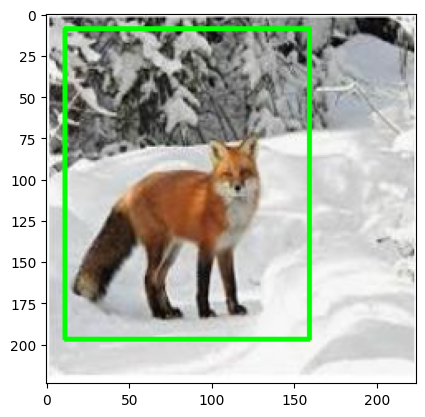

50 73 148 195
Clase predicha: 6


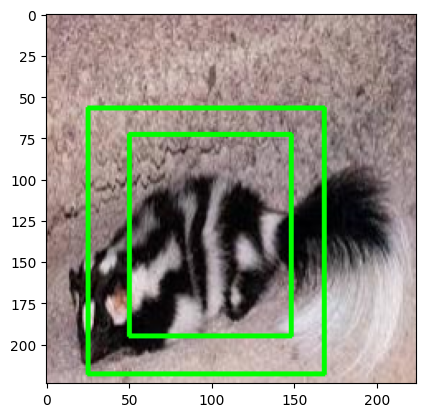

-2 -10 178 193
Clase predicha: 2


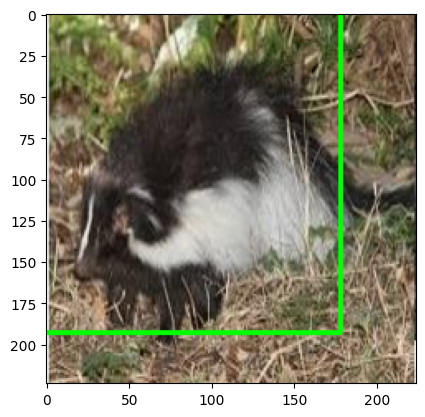

38 29 185 181
Clase predicha: 3


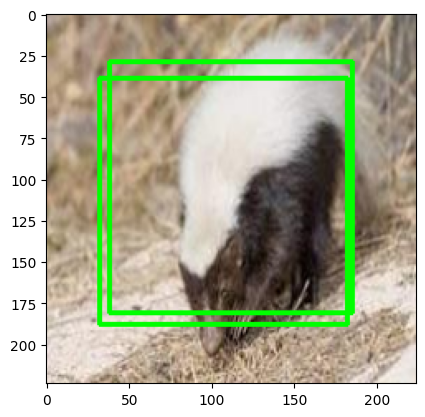

Diccionario: {'cat': 0, 'chicken': 1, 'cow': 2, 'dog': 3, 'fox': 4, 'goat': 5, 'horse': 6, 'person': 7, 'racoon': 8, 'skunk': 9}


In [19]:
#Se realiza la predicción con algunos datos
ejemplos=[5,21,18,13] #32,42,29,5
ejemplos_a_predecir=[]

#Se colocan las imágenes a predecir en una lista para luego mostrarlas con opencv y matplotlib
for ejm in ejemplos:
  img=x_test[ejm]
  ejemplos_a_predecir.append(img)

#Se realiza la conversión a un arreglo de Numpy
ejemplos_a_predecir=np.array(ejemplos_a_predecir)

#Se generan las predicciones para las imágenes
predicciones = modelo.predict(ejemplos_a_predecir)


#Se generan las gráficas para algunas imágenes y comprobar los valores predichos por el modelo
import matplotlib.pyplot as plt
import cv2
for i in range (len(ejemplos)):
  #Se almacenan las coordenadas de los bounding boxes
  xmin, ymin, xmax, ymax=predicciones[1][i][0],predicciones[1][i][1],predicciones[1][i][2],predicciones[1][i][3]
  print(int(xmin),int(ymin),int(xmax),int(ymax))

  #Se almacena la clase correspondiente. Para ello se usa "np.argmax", pues dicho arreglo que almace las predicciones es un arreglo
  #de las probabilidades de que dicho objeto en la imagen pertenezca a una clase
  clases = np.argmax(predicciones[0], axis = 1)

  #Se genera la gráfica con su bounding box y clase para cada imagen
  imagen=ejemplos[i]
  img=x_test[imagen]
  img=cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)
  print("Clase predicha:",clases[i])


  plt.imshow(img)
  plt.show()


print("Diccionario:",etiquetas)

In [ ]:
#Evaluar el modelo en la data de test
ev2=modelo.evaluate(x_test,test_targets)
print(ev2)

5/5 [==============================] - 4s 680ms/step - loss: 1563.0697 - cl_head_loss: 2.2599 - bb_head_loss: 1560.8097 - cl_head_accuracy: 0.1667 - bb_head_mean_squared_error: 1560.8097
[1563.0697021484375, 2.2599148750305176, 1560.8096923828125, 0.1666666716337204, 1560.8096923828125]


In [ ]:
step_loss,cl_loss,bb_loss,cl_accuracy,bb_mse=ev2[0],ev2[1],ev2[2],ev2[3],ev2[4]
print("Accuracy para el problema de clasificación:",cl_accuracy*100,"%")
print("MSE para el problema de bounding boxes:",bb_mse)

Accuracy para el problema de clasificación: 16.66666716337204 %
MSE para el problema de bounding boxes: 1560.8096923828125


In [ ]:
#CUANTIZACIÓN
#Debido a que el modelo ha sido entrenado, se aplicarán técnicas de cuantización, pero posteriores al entrenamiento.
#La cuantización, lo que va a hacer, es que el modelo va a ser reducido en tamaño, y así más apto para dispositivos que tienen menos memoria.
#De esta forma, mejorar la velocidad de "inferencia" en la red neuronal puede también mejorar, pues dicha operación es costosa computacionalmente

Cuantización post-entrenamiento:

In [ ]:
#Primero, se convertirá el modelo a uno más pequeño, haciendo uso de tensorflow.lite:
converter=tensorflow.lite.TFLiteConverter.from_keras_model(modelo)

#Acá se realiza la conversión del modelo
#Lo que se hace es "convertir" el modelo a un formato de modelo de ML más pequeño y eficiente:
modelo_tflite_sin_cuant = converter.convert()


In [ ]:
#Ya que el modelo ha sido "transformado" a uno más pequeño (sin haber aún aplicado la cuantización), se mostrará qué tanto ha sido reducido:
print("Tamaño del modelo lite sin cuantización (bytes):",len(modelo_tflite_sin_cuant))

Tamaño del modelo lite sin cuantización (bytes): 6632124


In [ ]:
#Si bien el modelo ya es un modelo "tflite", aún no se le ha aplicado la "cuantización". Eso quiere decir que, si se aplica
#el método, el tamaño del modelo deberá ser menor:
converter=tensorflow.lite.TFLiteConverter.from_keras_model(modelo)
#Acá se aplica la cuantización
converter.optimizations=[tensorflow.lite.Optimize.DEFAULT]
#Se realiza la conversión, pero con la cuantización
modelo_tflite_cuant = converter.convert()

In [ ]:
#Ahora, se imprime el tamaño del modelo lite cuantizado en bytes:
print("Tamaño del modelo lite cuantizado (bytes):",len(modelo_tflite_cuant))

Tamaño del modelo lite cuantizado (bytes): 1671936


El tamaño del modelo cuantizado se redujo significativamente.
El cuantizado que se usó, lo que hará es transformar todos los pesos de la red en números enteros. De esta manera, se usará menos espacio en memoria, lo cual puede impactar en el tiempo de procesamiento, y así hacerlo más eficiente. Sin embargo, puede afectar la precisión del modelo.